In [1]:
#Imports
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize, Resize, RandomCrop, RandomHorizontalFlip
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR  # or ReduceLROnPlateau

In [2]:
#Set Random Seed
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"
    patch_size = h // n_patches
    patches = torch.zeros(n, n_patches**2, c * patch_size * patch_size)

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d):
    result = torch.zeros(sequence_length, d)
    for i in range(sequence_length):
        for j in range(0, d, 2):
            result[i][j] = np.sin(i / (10000 ** (j / d)))
            if j + 1 < d:
                result[i][j + 1] = np.cos(i / (10000 ** (j / d)))
    return result

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=1):
        super(MyMSA, self).__init__()
        assert d % n_heads == 0, "Embedding dim must be divisible by number of heads"
        self.d_head = d // n_heads
        self.n_heads = n_heads

        self.qkv = nn.Linear(d, 3 * d)
        self.out_proj = nn.Linear(d, d)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x)  # [B, N, 3*D]
        qkv = qkv.view(B, N, 3, self.n_heads, self.d_head).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, heads, N, d_head]

        attn_weights = (q @ k.transpose(-2, -1)) / (self.d_head ** 0.5)  # [B, heads, N, N]
        attn = self.softmax(attn_weights)
        out = attn @ v  # [B, heads, N, d_head]
        out = out.transpose(1, 2).contiguous().view(B, N, D)  # [B, N, D]

        return self.out_proj(out)

class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        x = x + self.mhsa(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MyViT(nn.Module):
    def __init__(self, input_shape, patch_size, n_blocks, hidden_d, n_heads, out_d):
        super(MyViT, self).__init__()
        c, h, w = input_shape
        assert h % patch_size == 0 and w % patch_size == 0, "Image must be divisible by patch size"

        self.patch_size = patch_size
        self.n_patches_h = h // patch_size
        self.n_patches_w = w // patch_size
        self.n_patches = self.n_patches_h * self.n_patches_w
        patch_dim = c * patch_size * patch_size

        # Patch embedding
        self.patch_embedding = nn.Linear(patch_dim, hidden_d)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches, hidden_d))

        # Transformer encoder (custom)
        self.blocks = nn.Sequential(
            *[MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_d),
            nn.Linear(hidden_d, out_d)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        # Split into patches
        patches = x.unfold(2, ph, ph).unfold(3, pw, pw)  # [B, C, n_ph, n_pw, ph, pw]
        patches = patches.permute(0, 2, 3, 1, 4, 5)  # [B, n_ph, n_pw, C, ph, pw]
        patches = patches.contiguous().view(B, self.n_patches, -1)  # [B, n_patches, patch_dim]

        # Embed + position
        x = self.patch_embedding(patches) + self.pos_embedding  # [B, n_patches, hidden_d]

        # Custom transformer blocks
        x = self.blocks(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Classification
        return self.mlp_head(x)

In [4]:
# Define CIFAR-10 dataset transformations
transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 train and test sets
train_set = CIFAR10(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = CIFAR10(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


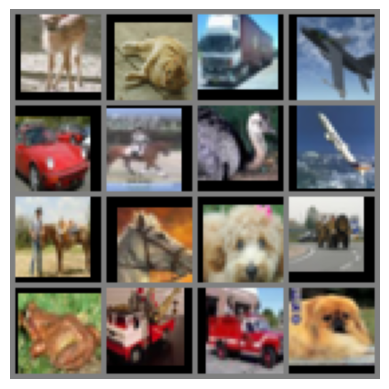

In [5]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Helper function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you normalized with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.axis('off')
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4))  # show first 16 images in a 4x4 grid

In [21]:
train_losses = []
val_losses = []

# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyViT(
    input_shape=(3, 32, 32),
    patch_size=8,        # 32x32 image → 4x4 grid = 16 patches
    n_blocks=4,
    hidden_d=64,
    n_heads=4,
    out_d=10
).to(device)


# Hyperparameters
N_EPOCHS = 100
LR = 0.005
PATIENCE = 5  # Early stopping patience
MIN_DELTA = 0.001  # Minimum improvement to reset early stopping
STEP_SIZE = 10  # StepLR scheduler step size
GAMMA = 0.5     # LR decay factor

optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Alternatively:
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(N_EPOCHS):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Scheduler Step ----
    scheduler.step()  # For StepLR
    # scheduler.step(val_loss)  # If using ReduceLROnPlateau

    # ---- Early Stopping Check ----
    if val_loss + MIN_DELTA < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_loss": best_val_loss
             }, "vit_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/100 | Train Loss: 1.8937 | Val Loss: 1.6902


Epoch 2/100 | Train Loss: 1.6352 | Val Loss: 1.5643


Epoch 3/100 | Train Loss: 1.5301 | Val Loss: 1.4721


Epoch 4/100 | Train Loss: 1.4561 | Val Loss: 1.4237


Epoch 5/100 | Train Loss: 1.4015 | Val Loss: 1.4001


Epoch 6/100 | Train Loss: 1.3555 | Val Loss: 1.3301


Epoch 7/100 | Train Loss: 1.3260 | Val Loss: 1.2922


Epoch 8/100 | Train Loss: 1.2865 | Val Loss: 1.2982


Epoch 9/100 | Train Loss: 1.2629 | Val Loss: 1.2881


Epoch 10/100 | Train Loss: 1.2353 | Val Loss: 1.2267


Epoch 11/100 | Train Loss: 1.1499 | Val Loss: 1.1560


Epoch 12/100 | Train Loss: 1.1219 | Val Loss: 1.1354


Epoch 13/100 | Train Loss: 1.1034 | Val Loss: 1.1185


Epoch 14/100 | Train Loss: 1.0864 | Val Loss: 1.1114


Epoch 15/100 | Train Loss: 1.0718 | Val Loss: 1.0977


Epoch 16/100 | Train Loss: 1.0597 | Val Loss: 1.0676


Epoch 17/100 | Train Loss: 1.0446 | Val Loss: 1.0856


Epoch 18/100 | Train Loss: 1.0318 | Val Loss: 1.0858


Epoch 19/100 | Train Loss: 1.0284 | Val Loss: 1.0573


Epoch 20/100 | Train Loss: 1.0127 | Val Loss: 1.0543


Epoch 21/100 | Train Loss: 0.9623 | Val Loss: 1.0239


Epoch 22/100 | Train Loss: 0.9501 | Val Loss: 1.0104


Epoch 23/100 | Train Loss: 0.9435 | Val Loss: 1.0167


Epoch 24/100 | Train Loss: 0.9321 | Val Loss: 1.0174


Epoch 25/100 | Train Loss: 0.9270 | Val Loss: 0.9971


Epoch 26/100 | Train Loss: 0.9200 | Val Loss: 1.0053


Epoch 27/100 | Train Loss: 0.9142 | Val Loss: 0.9954


Epoch 28/100 | Train Loss: 0.9129 | Val Loss: 0.9883


Epoch 29/100 | Train Loss: 0.9019 | Val Loss: 0.9871


Epoch 30/100 | Train Loss: 0.8969 | Val Loss: 0.9657


Epoch 31/100 | Train Loss: 0.8708 | Val Loss: 0.9647


Epoch 32/100 | Train Loss: 0.8589 | Val Loss: 0.9683


Epoch 33/100 | Train Loss: 0.8588 | Val Loss: 0.9652


Epoch 34/100 | Train Loss: 0.8507 | Val Loss: 0.9632


Epoch 35/100 | Train Loss: 0.8530 | Val Loss: 0.9509


Epoch 36/100 | Train Loss: 0.8486 | Val Loss: 0.9585


Epoch 37/100 | Train Loss: 0.8449 | Val Loss: 0.9541


Epoch 38/100 | Train Loss: 0.8428 | Val Loss: 0.9693


Epoch 39/100 | Train Loss: 0.8416 | Val Loss: 0.9395


Epoch 40/100 | Train Loss: 0.8374 | Val Loss: 0.9531


Epoch 41/100 | Train Loss: 0.8170 | Val Loss: 0.9453


Epoch 42/100 | Train Loss: 0.8134 | Val Loss: 0.9429


Epoch 43/100 | Train Loss: 0.8136 | Val Loss: 0.9431


Epoch 44/100 | Train Loss: 0.8099 | Val Loss: 0.9292


Epoch 45/100 | Train Loss: 0.8090 | Val Loss: 0.9367


Epoch 46/100 | Train Loss: 0.8017 | Val Loss: 0.9422


Epoch 47/100 | Train Loss: 0.8041 | Val Loss: 0.9316


Epoch 48/100 | Train Loss: 0.8039 | Val Loss: 0.9424


Epoch 49/100 | Train Loss: 0.7963 | Val Loss: 0.9265


Epoch 50/100 | Train Loss: 0.7995 | Val Loss: 0.9337


Epoch 51/100 | Train Loss: 0.7906 | Val Loss: 0.9220


Epoch 52/100 | Train Loss: 0.7849 | Val Loss: 0.9283


Epoch 53/100 | Train Loss: 0.7852 | Val Loss: 0.9199


Epoch 54/100 | Train Loss: 0.7835 | Val Loss: 0.9297


Epoch 55/100 | Train Loss: 0.7867 | Val Loss: 0.9298


Epoch 56/100 | Train Loss: 0.7847 | Val Loss: 0.9319


Epoch 57/100 | Train Loss: 0.7847 | Val Loss: 0.9401


Epoch 58/100 | Train Loss: 0.7878 | Val Loss: 0.9334
Early stopping at epoch 58


In [22]:
import pickle

with open("loss_history.pkl", "wb") as f:
    pickle.dump({"train_losses": train_losses, "val_losses": val_losses}, f)

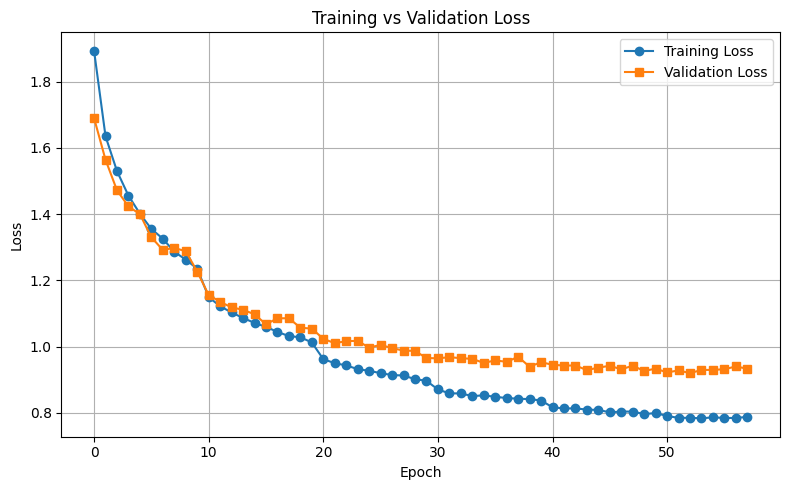

In [23]:
import matplotlib.pyplot as plt
import pickle

# Load the saved losses
with open("loss_history.pkl", "rb") as f:
    loss_dict = pickle.load(f)
    train_losses = loss_dict["train_losses"]
    val_losses = loss_dict["val_losses"]

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='s')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Save losses to file after training
import pickle
with open("loss_history.pkl", "wb") as f:
    pickle.dump((train_losses, val_losses), f)

In [25]:
# Set model to evaluation mode
model.eval()

correct, total = 0, 0
test_loss = 0.0

with torch.no_grad():  # No gradient calculation for evaluation
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get predictions and compute loss
        y_hat = model(x)
        loss = criterion(y_hat, y)

        # Accumulate test loss
        test_loss += loss.item()  # Use .item() to get the scalar value

        # Compute accuracy
        _, predicted = torch.max(y_hat, dim=1)  # Get the class predictions
        correct += (predicted == y).sum().item()  # Sum the number of correct predictions
        total += y.size(0)  # Total number of samples in this batch

# Calculate final average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = (correct / total) * 100

# Print results
print(f"Test Loss: {avg_test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Testing: 100%|██████████| 79/79 [00:03<00:00, 21.87it/s]

Test Loss: 0.92
Test Accuracy: 67.40%


In [26]:
# --------------------------------------------------
# Transfer Learning
# --------------------------------------------------



# --------------------------------------------------
# Dataset -- Just as an example
# --------------------------------------------------
transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = CIFAR10(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = CIFAR10(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False)

# --------------------------------------------------
# Load pretrained MyViT
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyViT(
    input_shape=(3, 32, 32),
    patch_size=8,
    n_blocks=4,
    hidden_d=64,
    n_heads=4,
    out_d=10
).to(device)

# Load checkpoint saved by pretraining
checkpoint = torch.load("vit_best.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])   # IMPORTANT


# --------------------------------------------------
# Freeze everything
# --------------------------------------------------
for param in model.parameters():
    param.requires_grad = False


# --------------------------------------------------
# Replace classification head
# --------------------------------------------------
in_features = model.mlp_head[1].in_features

model.mlp_head = nn.Sequential(
    nn.LayerNorm(in_features),
    nn.Linear(in_features, 10)
).to(device)

# Unfreeze head
for param in model.mlp_head.parameters():
    param.requires_grad = True


# --------------------------------------------------
# Fine-tuning Hyperparameters
# --------------------------------------------------
N_EPOCHS_FT = 5
LR_FT = 0.001
PATIENCE = 3
MIN_DELTA = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.mlp_head.parameters(), lr=LR_FT)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

best_val_loss = float("inf")
patience_counter = 0


# --------------------------------------------------
# Transfer Learning Loop
# --------------------------------------------------
for epoch in range(N_EPOCHS_FT):

    # -------- TRAIN --------
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} (Transfer Learning)", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_train += (y_hat.argmax(dim=1) == y).sum().item()
        total_train += y.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train


    # -------- VALIDATION using test_loader --------
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            val_loss += criterion(y_hat, y).item()

    avg_val_loss = val_loss / len(test_loader)


    print(f"Epoch {epoch+1}/{N_EPOCHS_FT} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}")


    scheduler.step()


    # -------- EARLY STOPPING --------
    if avg_val_loss + MIN_DELTA < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "vit_transfer_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/5 | Train Loss: 1.2332 | Train Acc: 62.86% | Val Loss: 0.9752


Epoch 2/5 | Train Loss: 0.8289 | Train Acc: 71.29% | Val Loss: 0.9471


Epoch 3/5 | Train Loss: 0.8068 | Train Acc: 71.60% | Val Loss: 0.9342


Epoch 4/5 | Train Loss: 0.8011 | Train Acc: 71.85% | Val Loss: 0.9368


Epoch 5/5 | Train Loss: 0.8004 | Train Acc: 71.76% | Val Loss: 0.9229


In [28]:
# Load best model after fine-tuning
model.load_state_dict(torch.load("vit_transfer_best.pth"))

<All keys matched successfully>